# Obligatorisk innlevering 2 - oppgave 2

I denne oppgaven skal vi forsøke å forutsi oppsigelser ved en arbeidsplass basert på en rekke variabler som f.eks alder, kjønn, utdannelse, lønn, osv.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, cross_val_predict, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import ttest_rel
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

In [2]:
# I denne oppgaven skal dere bruke følgende datasett:
df = pd.read_csv("./datasett2.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1677 entries, 0 to 1676
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        1677 non-null   int64 
 1   Age                       1677 non-null   int64 
 2   BusinessTravel            1677 non-null   object
 3   DailyRate                 1677 non-null   int64 
 4   Department                1677 non-null   object
 5   DistanceFromHome          1677 non-null   int64 
 6   Education                 1677 non-null   int64 
 7   EducationField            1677 non-null   object
 8   EmployeeCount             1677 non-null   int64 
 9   EnvironmentSatisfaction   1677 non-null   int64 
 10  Gender                    1677 non-null   object
 11  HourlyRate                1677 non-null   int64 
 12  JobInvolvement            1677 non-null   int64 
 13  JobLevel                  1677 non-null   int64 
 14  JobRole                 

In [4]:
df.shape

(1677, 35)

### Preprosessering:
For å forenkle håndteringen av kategoriske data har jeg her skrevet noe kode som gjør om strenger til intergers

Følgende kolonner er formatert som *object* og inneholder kategoriske variabler i form av strenger

In [5]:
kolonner_obj = df.select_dtypes(include=['object']).columns
print(kolonner_obj)

Index(['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole',
       'MaritalStatus', 'Over18', 'OverTime'],
      dtype='object')


I koden under omformer jeg strengene til integers og gir dere "nøkkelen" til å konvertere det tilbake igjen

In [6]:
for i in kolonner_obj:
    print("-----------")
    print(i)
    print("-----------")
    for num, j in enumerate(list(df[i].unique())):
        print("{} = {}".format(j,num))
        df[i].loc[df[i]==j] = num
    df[i] = pd.to_numeric(df[i])

-----------
BusinessTravel
-----------
Travel_Frequently = 0
Travel_Rarely = 1
Non-Travel = 2
-----------
Department
-----------
Research & Development = 0
Sales = 1
Human Resources = 2
-----------
EducationField
-----------
Medical = 0
Other = 1
Marketing = 2
Life Sciences = 3
Technical Degree = 4
Human Resources = 5
-----------
Gender
-----------
Male = 0
Female = 1
-----------
JobRole
-----------
Laboratory Technician = 0
Sales Representative = 1
Sales Executive = 2
Healthcare Representative = 3
Manager = 4
Manufacturing Director = 5
Research Scientist = 6
Human Resources = 7
Research Director = 8
-----------
MaritalStatus
-----------
Married = 0
Divorced = 1
Single = 2
-----------
Over18
-----------
Y = 0
-----------
OverTime
-----------
Yes = 0
No = 1


/tmp/ipykernel_33210/3482823818.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i].loc[df[i]==j] = num
/tmp/ipykernel_33210/3482823818.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i].loc[df[i]==j] = num
/tmp/ipykernel_33210/3482823818.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[i].loc[df[i]==j] = num
/tmp/ipykernel_33210/3482823818.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

I outputen fra koden nedenfor viser datatypen til de forskjellige kolonnene, som nå etter preprosesseringen bare består av integers (int64). 

In [7]:
print(df.dtypes)

id                          int64
Age                         int64
BusinessTravel              int64
DailyRate                   int64
Department                  int64
DistanceFromHome            int64
Education                   int64
EducationField              int64
EmployeeCount               int64
EnvironmentSatisfaction     int64
Gender                      int64
HourlyRate                  int64
JobInvolvement              int64
JobLevel                    int64
JobRole                     int64
JobSatisfaction             int64
MaritalStatus               int64
MonthlyIncome               int64
MonthlyRate                 int64
NumCompaniesWorked          int64
Over18                      int64
OverTime                    int64
PercentSalaryHike           int64
PerformanceRating           int64
RelationshipSatisfaction    int64
StandardHours               int64
StockOptionLevel            int64
TotalWorkingYears           int64
TrainingTimesLastYear       int64
WorkLifeBalanc

In [8]:
# Her deler jeg datasettet inn i egenskaper (X) og target (y) (fjerner også den første kolonnen siden det bare er en ID 
# og har dermed ingen prediktiv verdi)

X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

# Tilslutt deler jeg inn i et trening- og et testsett (75%/25%)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=0)

# PS: Ikke endre denne kodecellen!

#### Oppgave 2.1) 
Visualiser $y\_train$ og $y\_test$ i et histogram. Kan du, basert på figuren, se hva slags problem vi skal løse (regresjon/klassifisering)? Begrunn svaret

In [9]:
df

,id,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,0,36,0,599,0,24,3,0,1,4,...,80,1,10,2,3,10,0,7,8,0
1,1,35,1,921,1,8,3,1,1,1,...,80,1,4,3,3,4,2,0,3,0
2,2,32,1,718,1,26,3,2,1,3,...,80,2,4,3,3,3,2,1,2,0
3,3,38,1,1488,0,2,3,0,1,3,...,80,0,15,1,1,6,0,0,2,0
4,4,50,1,1017,0,5,4,0,1,2,...,80,0,31,0,3,31,14,4,10,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1672,1672,30,1,945,1,1,3,3,1,4,...,80,0,10,2,4,10,0,0,8,0
1673,1673,32,1,1303,0,2,3,3,1,1,...,80,1,10,3,4,4,2,1,3,0
1674,1674,29,0,1184,2,24,3,5,1,2,...,80,0,1,2,3,1,0,0,0,1
1675,1675,36,1,441,1,9,2,2,1,2,...,80,2,10,3,2,10,3,0,8,0


Text(0.5, 1.0, 'Histogram of y_train and y_test')

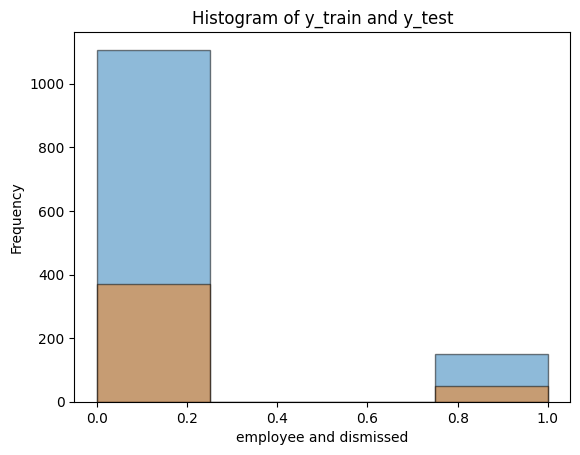

In [10]:
# Create histograms using matplotlib
plt.hist(y_train, bins=4, alpha=0.5, label='y_train', edgecolor='black')
plt.hist(y_test, bins=4, alpha=0.5, label='y_test', edgecolor='black')

# Add labels and title
plt.title('Target values')
plt.ylabel('Frequency')
plt.xlabel('employee and dismissed')
plt.title('Histogram of y_train and y_test')

**Svar:** Y er diskret og binær variabel. Dette betyr at det er et klassifiseringsproblem. Det er et ubalansert datasett siden det er stor ulikhet mellom de to ufallene i datasettet.

#### Oppgave 2.2)
Velg to modeller og gjør repeterte kryssvalideringer $(10)$ med $K=5$
* Velg hvorvidt du vil bruke "default" hyperparamtre for modellene eller om du vil gjøre et hyperparametersøk
* Skår ytelsen til modellene ved hjelp av F1-score og accuracy
* Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
* Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene 
* Tolk resultatene skriftlig til slutt 


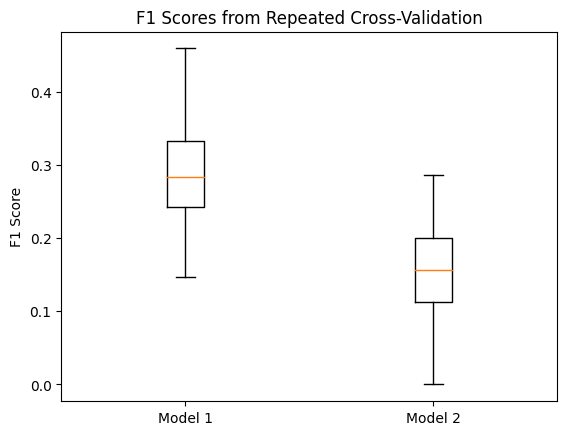

F1-scores are significantly different. Model 1 is better than Model 2.


In [11]:
# Velg modellene
model1 = DecisionTreeClassifier()  
model2 = RandomForestClassifier()

# Velger å bruke default hyperparametre. Ellers må det fylles inn under her:
# hyperparameter-søk:
# param_grid = {'param_name': [value1, value2, ...]}
# grid_search = GridSearchCV(model1, param_grid, cv=5)
# model1 = grid_search.best_estimator_

# Gjør kryssvalidering
cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)
f1_scores_model1 = cross_val_score(model1, X_train, y_train, scoring='f1', cv=cv)
f1_scores_model2 = cross_val_score(model2, X_train, y_train, scoring='f1', cv=cv)

# Skår ytelsen ved hjelp av F1-score og accuracy på testsettet
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)

y_pred_model1 = model1.predict(X_test)
y_pred_model2 = model2.predict(X_test)

f1_test_model1 = f1_score(y_test, y_pred_model1)
f1_test_model2 = f1_score(y_test, y_pred_model2)

accuracy_test_model1 = accuracy_score(y_test, y_pred_model1)
accuracy_test_model2 = accuracy_score(y_test, y_pred_model2)

# Visualiser F1-skårene som et boksplott
plt.boxplot([f1_scores_model1, f1_scores_model2], labels=['Model 1', 'Model 2'])
plt.ylabel('F1 Score')
plt.title('F1 Scores from Repeated Cross-Validation')
plt.show()

# Utfør en to-sidig T-test på F1-skårene
t_statistic, p_value = ttest_rel(f1_scores_model1, f1_scores_model2)

# Tolk resultatene
alpha = 0.05
if p_value < alpha:
    print("F1-scores are significantly different. Model 1 is better than Model 2.")
else:
    print("No significant difference in F1-scores between Model 1 and Model 2.")

Resultatene av den to-sidige T-testen indikerer at det er en signifikant forskjell i F1-skårene mellom Model 1 og Model 2. Dermed kan vi konkludere med at model1 presterer bedre enn model2.

#### Oppgave 2.3) 
Tren de samme modellene men denne gangen med et balansert datasett
* Bruk imbalaced learn og SMOTE til å oppsample minioritetsklassen (bare oppsample treningsdataene i kryssvalideringen - ikke valideringsdataene)
* Skår ytelsen til modellene ved hjelp av F1-score og accuracy
* Visualiser F1-skårene fra de repeterte kryssvalideringene som et boksplot
* Undersøk om modell 1 er bedre eller dårligere enn modell 2 ved å gjøre en to-sidig T-test på F1-skårene fra de repeterte kryssvalideringene 
* Tolk resultatene og sammenlign resultatene med 2.2) 

In [12]:
#TODO: repeterte kryssvalideringer for de samme to modellene som i oppgave 2.2, men denne gangen med SMOTE-oppsampling 
#from imblearn.over_sampling import SMOTE

In [13]:
model1 = DecisionTreeClassifier()  

model1_smote = make_pipeline(SMOTE(random_state=42), model1)

cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

f1_scores_model1_smote = cross_val_score(model1_smote, X_train, y_train, scoring='f1', cv=cv)
f1_scores_model1_smote

array([0.34883721, 0.37681159, 0.38235294, 0.34782609, 0.43478261,
       0.33333333, 0.27586207, 0.34883721, 0.35294118, 0.30555556,
       0.34567901, 0.42666667, 0.28571429, 0.20289855, 0.34666667,
       0.34210526, 0.275     , 0.32876712, 0.23880597, 0.27586207,
       0.35897436, 0.46153846, 0.27272727, 0.51515152, 0.24615385,
       0.29032258, 0.23880597, 0.34883721, 0.30769231, 0.29411765,
       0.30985915, 0.36363636, 0.49350649, 0.33333333, 0.34567901,
       0.39393939, 0.32      , 0.26086957, 0.3902439 , 0.29333333,
       0.36842105, 0.20895522, 0.3908046 , 0.36363636, 0.3       ,
       0.20289855, 0.3255814 , 0.25714286, 0.36585366, 0.4375    ])

In [14]:
model2 = RandomForestClassifier()

model2_smote = make_pipeline(SMOTE(random_state=42), model2)

cv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

f1_scores_model2_smote = cross_val_score(model2_smote, X_train, y_train, scoring='f1', cv=cv)
f1_scores_model2_smote

array([0.44897959, 0.26666667, 0.47058824, 0.37037037, 0.43243243,
       0.49122807, 0.43243243, 0.33333333, 0.23809524, 0.48      ,
       0.44827586, 0.44897959, 0.41666667, 0.3255814 , 0.37735849,
       0.44897959, 0.35087719, 0.4       , 0.37209302, 0.20689655,
       0.39130435, 0.4       , 0.23809524, 0.46153846, 0.33962264,
       0.24242424, 0.46428571, 0.44827586, 0.3902439 , 0.4       ,
       0.24390244, 0.3902439 , 0.41509434, 0.53846154, 0.32653061,
       0.52173913, 0.41509434, 0.34782609, 0.38461538, 0.47826087,
       0.39130435, 0.36      , 0.37931034, 0.32653061, 0.28571429,
       0.41666667, 0.18867925, 0.41025641, 0.49056604, 0.48      ])

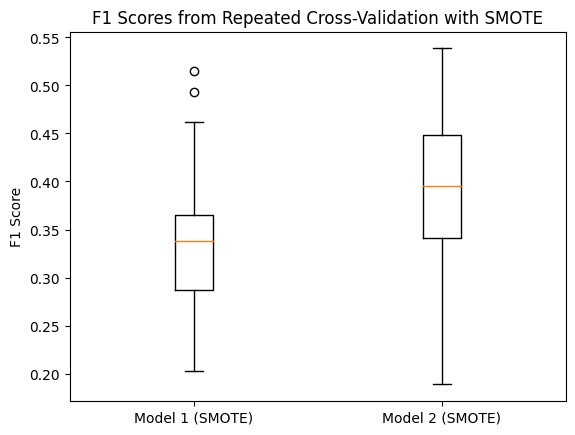

F1-scores with SMOTE are significantly different. Model 2 (SMOTE) is better than Model 1 (SMOTE).


In [15]:
# Visualiser F1-skårene som et boksplott
plt.boxplot([f1_scores_model1_smote, f1_scores_model2_smote], labels=['Model 1 (SMOTE)', 'Model 2 (SMOTE)'])
plt.ylabel('F1 Score')
plt.title('F1 Scores from Repeated Cross-Validation with SMOTE')
plt.show()

# Utfør en to-sidig T-test på F1-skårene med og uten SMOTE
t_statistic_smote, p_value_smote = ttest_rel(f1_scores_model1_smote, f1_scores_model2_smote)

# Tolk resultatene
alpha = 0.05
if p_value_smote < alpha:
    print("F1-scores with SMOTE are significantly different. Model 2 (SMOTE) is better than Model 1 (SMOTE).")
else:
    print("No significant difference in F1-scores with SMOTE between Model 1 and Model 2.")

Boksplottet viser at Model 2 er bedre enn Model 1. Model 2 har høyere f1-score. Gjennomsnittet for model 2 er ~0.40 og gjennomsnittet for model 1 er ~0.32.

#### Oppgave 2.4)
Tren den beste modellen på nytt og utfør prediksjon på testsettet. Mål nå ytelsen på testsettet ved bruk av sensitivitet, spesifisitet og presisjon, itillegg til F1-skår og accuracy

In [16]:
from sklearn.metrics import confusion_matrix, classification_report

# Tren den beste modellen på nytt
best_model = model2_smote

# Tren modellen på hele treningssettet (inkludert valideringsdataene)
best_model.fit(X_train, y_train)

# Gjør prediksjoner på testsettet
y_pred_test = best_model.predict(X_test)

# Beregn og skriv ut resultater
conf_matrix = confusion_matrix(y_test, y_pred_test)
classification_rep = classification_report(y_test, y_pred_test)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_rep)

Confusion Matrix:
[[355  15]
 [ 34  16]]

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94       370
           1       0.52      0.32      0.40        50

    accuracy                           0.88       420
   macro avg       0.71      0.64      0.67       420
weighted avg       0.87      0.88      0.87       420



#### Oppgave 2.5)
Del opp testsettet basert på kjønn og gjør en analyse av sensitivitet, spesifisitet og presisjon for menn og det samme for kvinner. Skriv ut og diskuter resultatet og forsøk å svar på følgende spørsmål:
* Er modellen like god for begge kjønn? 
* Hvis ikke, hva tror du er årsaken og hvilke tiltak kan vi gjøre for å forbedre modellen? 

In [17]:
# Anta at best_model er den modellen du ønsker å evaluere (for eksempel, hvis model1_smote var den beste modellen)
# Tren modellen på hele treningssettet (inkludert valideringsdataene)
best_model.fit(X_train, y_train)

# Gjør prediksjoner på testsettet
y_pred_test = best_model.predict(X_test)

# Opprett en DataFrame med prediksjoner og kjønn fra testsettet
results_df = pd.DataFrame({'Prediction': y_pred_test, 'Gender': X_test['Gender']})

# Del opp testsettet basert på kjønn
women_results = results_df[results_df['Gender'] == 1]
men_results = results_df[results_df['Gender'] == 0]

# Evaluer resultatene for kvinner
precision_women = precision_score(y_test[women_results.index], women_results['Prediction'])
recall_women = recall_score(y_test[women_results.index], women_results['Prediction'])
accuracy_women = accuracy_score(y_test[women_results.index], women_results['Prediction'])
f1_women = f1_score(y_test[women_results.index], women_results['Prediction'])
conf_matrix_women = confusion_matrix(y_test[women_results.index], women_results['Prediction'])

# Evaluer resultatene for menn
precision_men = precision_score(y_test[men_results.index], men_results['Prediction'])
recall_men = recall_score(y_test[men_results.index], men_results['Prediction'])
accuracy_men = accuracy_score(y_test[men_results.index], men_results['Prediction'])
f1_men = f1_score(y_test[men_results.index], men_results['Prediction'])
conf_matrix_men = confusion_matrix(y_test[men_results.index], men_results['Prediction'])

# Skriv ut resultatene
print("Results for Women:")
print(f"Precision: {precision_women}")
print(f"Recall: {recall_women}")
print(f"Accuracy: {accuracy_women}")
print(f"F1 Score: {f1_women}")
print(f"Confusion Matrix:\n{conf_matrix_women}")

print("\nResults for Men:")
print(f"Precision: {precision_men}")
print(f"Recall: {recall_men}")
print(f"Accuracy: {accuracy_men}")
print(f"F1 Score: {f1_men}")
print(f"Confusion Matrix:\n{conf_matrix_men}")


Results for Women:
Precision: 0.5
Recall: 0.21428571428571427
Accuracy: 0.9161676646706587
F1 Score: 0.3
Confusion Matrix:
[[150   3]
 [ 11   3]]

Results for Men:
Precision: 0.5185185185185185
Recall: 0.3888888888888889
Accuracy: 0.8616600790513834
F1 Score: 0.4444444444444444
Confusion Matrix:
[[204  13]
 [ 22  14]]


Når modellen er oppskalert ser det ut som den blir mer nøyaktig for den kvinner (som ble oppskalert) enn for menn, men at de andre metrikkene ikke er like gode. Modellen ser ut som de er omtrent like gode. Kan sikkert justere mer for å få det enda bedre.

In [18]:
# Her er fordelingen av kjønn i datasettet før smote. Det er flere menn enn kvinner i datasettet, noe som gjør datasettet ubalansert.
gender = df['Gender'] # menn = 0 and women = 1
gender_count = gender.value_counts()
gender_count

Gender
0    1064
1     613
Name: count, dtype: int64

Etter at en gjør en oppskalering med SMOTE skal det være like mange kvinner og menn i datasettet.

Kjør denne cellen til slutt og legg ved den genererte requirements.txt fila i pull requestet: 

!pip freeze > requirements.txt